<img src="https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png" style="float: left; margin: 15px;">

## Naive Bayes Spam Filter Using SpamAssassin Data

<br>

---

In this lab, we will write our own spam filter -- one of the many practical uses of Naive Bayes. We will additionally explore methods for visualizing text features in an effort to gain insight and improve our models.

### Background

The statistical approach for classifying spam was championed by Paul Graham, founder of Y Combinator. We highly recommend you read his classic (and very readable!) essay [A Plan for Spam](http://www.paulgraham.com/spam.html) to gain insight into why Naive Bayes works so well with spam.

The reason why Naive Bayes works incredibly well to classify spam is because spam aligns with the independence assumption. Certain keywords in emails -- taken by themselves (e.g. Nigeria / prince) -- typically indicate a spam message.

In this lab, the word **ham** indicates an email message that was authorized by the user. Sometimes we receive advertising emails that look like spam, yet we agreed to receive them. This fact can make spam detection more difficult. For a challenge, try classifying the `hard_ham` dataset below.

# Spam Lab



### 1. Download the data

We are using the data files from the SpamAssassin dataset:

+ https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
+ https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
+ https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2

From the command line, you can either use ```curl``` to download into the current directory. For an example of each:

    curl http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2 > 20021010_easy_ham.tar.bz2

You can use ```tar xvf <file>``` to extract into the current directory (x - extract, v - verbose, f - read from file). For example:

    tar xvf 20021010_easy_ham.tar.bz2

### Imports

In [23]:
import glob

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

### 1. Get directory contents

In [3]:
# NOTE: Ensure base_dir points to the base directory where you extracted your data files!
#   Inside this directory should be three folders -- easy_ham, hard_ham, and spam.

base_dir = './datasets'
easy_ham_files = glob.glob(base_dir + "/easy_ham/*")
hard_ham_files = glob.glob(base_dir + "/hard_ham/*")
spam_files = glob.glob(base_dir + "/spam/*")
spam_files[:10]

['./datasets/spam/0355.94ebf637e4bd3db8a81c8ce68ecf681d',
 './datasets/spam/0395.bb934e8b4c39d5eab38f828a26f760b4',
 './datasets/spam/0485.9021367278833179285091e5201f5854',
 './datasets/spam/0343.0630afbe4ee1ffd0db0ffb81c6de98de',
 './datasets/spam/0125.44381546181fc6c5d7ea59e917f232c5',
 './datasets/spam/0108.4506c2ef846b80b9a7beb90315b22701',
 './datasets/spam/0112.ec411d26d1f4decc16af7ef73e69a227',
 './datasets/spam/0060.140f80780520fa19b360ddcb05838a67',
 './datasets/spam/0392.9e194dfff92f7d9957171b04a8d4b957',
 './datasets/spam/0441.b820c1999715c2e5ded6418d2b17723c']

In [4]:
# use Python 3's open function, which supports the encoding parameter
from io import open

# Create list of full-text of all ham and spam emails

# read the easy ham files into a list
easy_ham_text = []
for filename in easy_ham_files:
    with open(filename, 'r', encoding='iso-8859-15') as f:
        easy_ham_text.append(f.read())

# read the easy ham files into a list
hard_ham_text = []
for filename in hard_ham_files:
    with open(filename, 'r', encoding='iso-8859-15') as f:
        hard_ham_text.append(f.read())
        
# read the spam files into a list
spam_text = []
for filename in spam_files:
    with open(filename, 'r', encoding='iso-8859-15') as f:
        spam_text.append(f.read())

print(easy_ham_text[0])

From rssfeeds@jmason.org  Mon Sep 30 13:43:46 2002
Return-Path: <rssfeeds@example.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id AE79816F16
	for <jm@localhost>; Mon, 30 Sep 2002 13:43:46 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Mon, 30 Sep 2002 13:43:46 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8U81fg21359 for
    <jm@jmason.org>; Mon, 30 Sep 2002 09:01:41 +0100
Message-Id: <200209300801.g8U81fg21359@dogma.slashnull.org>
To: yyyy@example.com
From: gamasutra <rssfeeds@example.com>
Subject: Priceless Rubens works stolen in raid on mansion
Date: Mon, 30 Sep 2002 08:01:41 -0000
Content-Type: text/plain; encoding=utf-8
Lines: 6
X-Spam-Status: No, hits=-527.4 required=5.0
	tests=AWL,DATE_IN_PAST_03_06,T_URI_COUNT_0_1
	version=2.50-cvs
X-Spam

In [5]:
# Let's merge all of the emails into a single list of emails -- this is our data!
ham_and_spam_text = easy_ham_text + spam_text    # extends the lists

In [6]:
# How imbalanced is our dataset?

print(len(spam_text))
print(len(easy_ham_text))
print(len(ham_and_spam_text))

467
2374
2841


### 2. Label the data

We now have `ham_and_spam_text`, a single list containing our emails. However, now we need this data to be labeled with what we will predict. In this case, we will make a list of 0s and 1s indicating whether each of these emails is ham (0) or spam (1). Can you make this list, given how we combined the spam and ham into one list above?

In [7]:
df = pd.DataFrame([[text,"1"] if text in spam_text else [text,"0"] for text in ham_and_spam_text],
                            columns=["text","spam"])

In [8]:
df.head()


,text,spam
0,From rssfeeds@jmason.org Mon Sep 30 13:43:46 ...,0
1,From fork-admin@xent.com Tue Sep 3 14:24:41 ...,0
2,From exmh-users-admin@redhat.com Wed Sep 11 1...,0
3,From fork-admin@xent.com Mon Sep 2 16:22:12 ...,0
4,From rssfeeds@jmason.org Fri Sep 27 10:40:59 ...,0


### 3. Transform the emails into features
 
We will be using cross validation later to assess performance, so feel free to fit it on the entire dataset for now.

#### 3.A. Fit the model on your data using `CountVectorizer`

Using `CountVectorizer` ONLY, transform each email into features. Consider now or later removing stopwords, trying different ngram sizes, making all words lowercase, and/or creating your own features (e.g. presence of an unsubscribe link!). 

In [9]:
# First we are going to create a fct to stemmer the words in the email
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
# Return a callable that handles preprocessing and tokenization
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [10]:
# We can now apply it using the countvectorizer from sklearn:
print(" ".join(stemmed_words(df.iloc[0,0])))
print("\n",df.iloc[0,0])

from rssfeed jmason org mon sep 30 13 43 46 2002 return path rssfeed exampl com deliv to yyyi localhost exampl com receiv from localhost jalapeno 127 by jmason org postfix with esmtp id ae79816f16 for jm localhost mon 30 sep 2002 13 43 46 0100 ist receiv from jalapeno 127 by localhost with imap fetchmail for jm localhost singl drop mon 30 sep 2002 13 43 46 0100 ist receiv from dogma slashnul org localhost 127 by dogma slashnul org 11 11 with esmtp id g8u81fg21359 for jm jmason org mon 30 sep 2002 09 01 41 0100 messag id 200209300801 g8u81fg21359 dogma slashnul org to yyyi exampl com from gamasutra rssfeed exampl com subject priceless ruben work stolen in raid on mansion date mon 30 sep 2002 08 01 41 0000 content type text plain encod utf line spam statu no hit 527 requir test awl date_in_past_03_06 t_uri_count_0_1 version 50 cv spam level url http www newsisfre com click 8381145 215 date 2002 09 30t03 04 58 01 00 art fourth art raid on philanthropist home onc target by the ira and dubl

In [11]:
countv = CountVectorizer(stop_words='english',
                       decode_error='ignore',
                       analyzer=stemmed_words)


#### 3.B. Transform the data

In [13]:
train_X = countv.fit_transform(df.text)

#### 3.C. Create a sparse matrix for scikit-learn

Create a dense 2-D ndarray `X` from the sparse matrix. Make a 1-D ndarray `y` (the list of labels you created earlier).

In [14]:
X = train_X.todense()
y = df.spam

In [15]:
words = countv.get_feature_names()

In [16]:
df  = pd.DataFrame(X, columns=words)

In [17]:
X.shape, y.shape, df.shape

((2841, 69130), (2841,), (2841, 69130))

### 4. Understand and visualize your features

Sometimes you may find it difficult to visualize text data. This section provides some exercises that give you insight into how you may modify your text features for improved performance.

#### 4.A. Understand sparse matrices and the transform

**For email index 1, print(a list of words and counts, sorted by descending count.** Use only the `train_X` sparse matrix along with the `get_feature_names()` method of your vectorizer. The index of each column in `train_X` refers to a word. That word is given by the element at that same index in `get_feature_names()`!

In [18]:
bag = sorted(list(zip(train_X[0].indices, train_X[0].data)),key=lambda x: -x[1])
bag[:5]

[(46169, 6), (6738, 6), (51111, 6), (26175, 5), (9487, 5)]

In [19]:
[(words[index],count) for index, count in bag][:5]

[('localhost', 6), ('2002', 6), ('org', 6), ('com', 5), ('30', 5)]

In [20]:
bag_ = df.iloc[0].sort_values(ascending=False)
bag  = [(word, count) for word, count in zip (bag_.index, bag_.values)]
bag[:5]

[('2002', 6), ('org', 6), ('localhost', 6), ('sep', 5), ('mon', 5)]

- Notice that the most common words in the email are garbage words from the email header! 
- You can likely improve your model by filtering these in some way.

#### 4.B. Using a histogram, visualize the number of emails each word is in.

What distribution is it? From this histogram, will most words in your model be noise or signal? Seeing this histogram, what can you likely do to improve your model? (Hint: To quickly graph this, use `np.sum` on the dense matrix `X` of word counts!)

In [21]:
wpe = np.sum(X,axis=0)
wpe[wpe < 12].shape

(1, 63035)

#### 4.C. Using a histogram, visualize the number of words each email contains.

What is the distribution? Are there any outlier emails? Can you find an explanation why there is there likely a spike in the histogram (e.g. are the emails in this dataset of a particular type?) 

- Plot the distribution of number of words for spam emails on top of the distribution for ham emails! Would this be a useful additional feature?

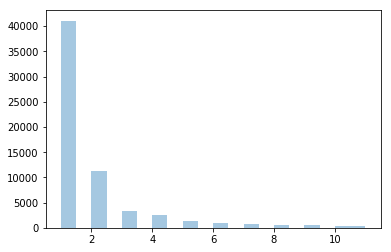

In [30]:
sns.distplot(wpe[wpe < 12], bins=20, hist=True, kde=False) ;

In [38]:
epw = np.sum(X,axis=1)

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


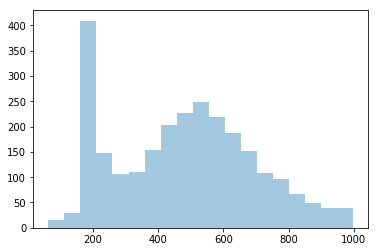

In [39]:
sns.distplot(epw[epw < 1000], hist=True, kde=False) ;

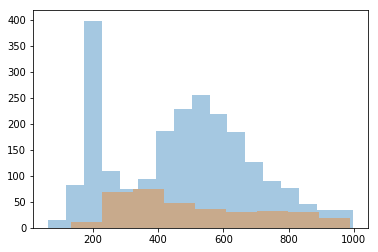

In [40]:
sns.distplot(epw[(y == "0")&[x[0] for x in (epw < 1000).tolist()] ], hist=True, kde=False) ;
sns.distplot(epw[(y == "1")&[x[0] for x in (epw < 1000).tolist()] ], hist=True, kde=False) ;

### 5. Estimate generalization accuracy

Use `cross_val_score` with the models `BernoulliNB` and `MultinomialNB` to assess how well these models classify emails. Can you guess why one may perform better than the other?

In [42]:
berno = BernoulliNB()
multy = MultinomialNB()

In [43]:
cross_val_score(berno, X, y, cv=5).mean(), cross_val_score(multy, X, y, cv=5).mean()

(0.9208061163963537, 0.9813429569584837)

### 6. Confusion matrix and Classification report

Recall that to make a confusion matrix, we will need a specific split. So, use `test_train_split`, manually fit the model using the best performer, then find the confusion matrix and classificaation report (in the `metrics` package). Is your model worse at Type I or Type II errors?

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [45]:
multy.fit(X_train, y_train)
multy.score(X_test, y_test)


0.9704641350210971

In [46]:
confusion_matrix(y_test, multy.predict(X_test))

array([[589,   1],
       [ 20, 101]])

In [47]:
print(classification_report(y_test, multy.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       590
           1       0.99      0.83      0.91       121

   micro avg       0.97      0.97      0.97       711
   macro avg       0.98      0.92      0.94       711
weighted avg       0.97      0.97      0.97       711



### 7. Test your model on the hard_ham

Does it perform as well?

In [50]:
hard_ham = countv.transform(hard_ham_text)
Xhard = hard_ham.todense()
yhard = [0 for _ in range(len(Xhard))]

len(yhard), Xhard.shape, X_train.shape

(231, (231, 69130), (2130, 69130))

In [51]:
multy.score(Xhard, yhard)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:182: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


0.0

In [53]:
prediction = multy.predict(Xhard)

In [54]:
prediction = prediction.astype(int)

In [56]:
confusion_matrix(yhard, prediction)

array([[ 79, 152],
       [  0,   0]])

In [58]:
print(classification_report(yhard, prediction))

              precision    recall  f1-score   support

           0       1.00      0.34      0.51       231
           1       0.00      0.00      0.00         0

   micro avg       0.34      0.34      0.34       231
   macro avg       0.50      0.17      0.25       231
weighted avg       1.00      0.34      0.51       231



/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### 8. Improve your model by looking at mispredictions

print(the most common words in your false positives of the hard hams versus the spams. (Perhaps write a function of step 4A. Consider using a `collections.Counter` to combine the counts!) Does comparing the most frequent words in the hard ham to those in the spam give you some ideas for how to distinguish between them? What extra features might you add to your model?

In [59]:
from collections import Counter

In [60]:
counter = Counter(np.sum(train_X.toarray(), axis=1))
counter.most_common()

[(180, 25),
 (178, 17),
 (179, 17),
 (186, 15),
 (182, 15),
 (187, 15),
 (175, 14),
 (181, 14),
 (202, 13),
 (176, 12),
 (172, 12),
 (173, 12),
 (171, 11),
 (177, 11),
 (191, 11),
 (528, 11),
 (206, 11),
 (444, 10),
 (183, 10),
 (174, 10),
 (588, 10),
 (195, 10),
 (478, 10),
 (200, 9),
 (511, 9),
 (235, 9),
 (556, 9),
 (565, 9),
 (201, 9),
 (169, 9),
 (188, 8),
 (431, 8),
 (486, 8),
 (572, 8),
 (585, 8),
 (612, 8),
 (495, 8),
 (441, 8),
 (623, 8),
 (489, 8),
 (210, 8),
 (625, 8),
 (196, 8),
 (563, 8),
 (189, 8),
 (488, 8),
 (427, 8),
 (610, 8),
 (515, 7),
 (236, 7),
 (497, 7),
 (558, 7),
 (595, 7),
 (469, 7),
 (479, 7),
 (451, 7),
 (190, 7),
 (554, 7),
 (517, 7),
 (538, 7),
 (216, 7),
 (510, 7),
 (575, 7),
 (442, 7),
 (522, 7),
 (698, 7),
 (192, 7),
 (184, 7),
 (519, 7),
 (701, 7),
 (618, 7),
 (512, 7),
 (560, 7),
 (241, 7),
 (516, 7),
 (403, 7),
 (432, 7),
 (552, 7),
 (421, 7),
 (571, 7),
 (643, 7),
 (198, 7),
 (410, 7),
 (379, 6),
 (669, 6),
 (692, 6),
 (542, 6),
 (405, 6),
 (681, 6)

In [61]:
[words[c[1]] for c in counter.most_common(5)]

['000007070213', '00000254', '00000254', '000001c266a5', '000001c266a5']

### Extensions

- Can you improve the score on the hard ham?
- Try to improve your model by changing or tweaking the model type. (e.g. LogisticRegression/RandomForests) Why do bigrams result in a lower accuracy? (Because nearly all of them are single-email, so they actually add MORE noise!)
- Remove features from your model, e.g. junk words.
- Add additional features to your model. Can you specifically come up with ideas that might detect spam vs. ham? For example, does an email have an unsubscribe link?